In [1]:
import cobra
import libsbml
from cobra.core import Metabolite, Reaction
import pandas as pd
df = pd.read_excel("ProcessedData_v2.xlsx")
from cobra import flux_analysis
ModelF = cobra.io.read_sbml_model("CAM_12PModel_v2_Stijn.xml")
ModelF.solver="glpk"
cobra.flux_analysis.pfba(ModelF)

PEPC_rxn = ModelF.reactions.get_by_id("PEPCARBOX_RXN_c7")
print(PEPC_rxn.flux)
print("-------")
phloem_rxn = ModelF.reactions.get_by_id("Diel_phloem_export")      #Phloem export represents output of the model (=sucrose + amino acids)    
print(phloem_rxn.flux)
print("-------")

#adding maintenance cost
PPFD = 100                            #light intensity of the model
ATPase = (0.0049*PPFD) + 2.7851       #non-growth assocaited maintenance (NGAM) cost based on light - see Topfer et al 2020 Supplemental information section 1.2.3
for i in range(1,13):
    ModelF.reactions.get_by_id("ATPase_tx"+str(i)).lower_bound = ATPase
    ModelF.reactions.get_by_id("ATPase_tx"+str(i)).upper_bound = ATPase
    
    #Setting NADPH demand to 1/3 of ATP demand and distributing this demand to cytosol, plastid and mitochondria based on Cheung et al 2013 (doi: 10.1111/tpj.12252)
    ModelF.reactions.get_by_id("NADPHoxc_tx"+str(i)).lower_bound = ATPase/9
    ModelF.reactions.get_by_id("NADPHoxc_tx"+str(i)).upper_bound = ATPase/9
    
    ModelF.reactions.get_by_id("NADPHoxp_tx"+str(i)).lower_bound = ATPase/9
    ModelF.reactions.get_by_id("NADPHoxp_tx"+str(i)).upper_bound = ATPase/9
    
    ModelF.reactions.get_by_id("NADPHoxm_tx"+str(i)).lower_bound = ATPase/9
    ModelF.reactions.get_by_id("NADPHoxm_tx"+str(i)).upper_bound = ATPase/9
    
met = ModelF.metabolites.PROTON_e1
for rxn in met.reactions:
    if round(rxn.flux,3)!=0:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print("-------")
        
cobra.flux_analysis.pfba(ModelF)

PEPC_rxn = ModelF.reactions.get_by_id("PEPCARBOX_RXN_c7")
print(PEPC_rxn.flux)
print("-------")
phloem_rxn = ModelF.reactions.get_by_id("Diel_phloem_export")
print(phloem_rxn.flux)
#ModelF.metabolites.PROTON_c6.summary()
#ModelF.metabolites.PROTON_m6.summary()
#ModelF.metabolites.PROTON_p1.summary()

4.450782702947559
-------
0.42999264936692144
-------
PROTON_ATPase_c1	0.3105325415071109
0.65 ATP_c1 + 0.45 PROTON_c1 + WATER_c1 + 0.35 aATP_c1 --> 0.5 ADP_c1 + PROTON_e1 + 0.7 Pi_c1 + 0.5 aADP_c1 + 0.3 aPi_c1
-------
Phloem_output_tx1	-0.3097224281318271
0.0022970297 4_AMINO_BUTYRATE_c1 + 0.0004186704 ARG_c1 + 0.0015049505 ASN_c1 + 0.0004186704 CYS_c1 + 0.0792079208 FRU_c1 + 0.0693069307 GLC_c1 + 0.0240792079 GLN_c1 + 0.0124356436 GLT_c1 + 0.0007128713 GLY_c1 + 0.0004186704 HIS_c1 + 0.0017425743 ILE_c1 + 0.0020594059 LEU_c1 + 0.0022178218 LYS_c1 + 0.0038811881 L_ALPHA_ALANINE_c1 + 0.006019802 L_ASPARTATE_c1 + 0.0004186704 MET_c1 + 0.0057029703 PHE_c1 + 0.9603960396 PROTON_e1 + 0.0004186704 PRO_c1 + 0.003960396 SER_c1 + 0.0068910891 THR_c1 + 0.0004186704 TRP_c1 + 0.0004186704 TYR_c1 + 0.0027722772 VAL_c1 + 0.7326732673 sSUCROSE_b1 --> 0.9603960396 PROTON_c1 + Phloem_e1
-------
5.8315578352997575
-------
0.35750555178863164


In [2]:
ModelF3 = ModelF.copy()

In [3]:
#Constraint stuff
#Constrain ATP_ADP_Pi_pc to 0 (we know NTT, plastidic nucleotide transporter is only active in importing ATP to chloroplast at night or in non-photosynthetic tissues (Reinhold et al., 2007; Flugge et al., 2011; Voon and Lim, 2019))

for i in range(1,7):    
    ModelF3.reactions.get_by_id("ATP_ADP_Pi_pc"+str(i)).lower_bound = 0
    ModelF3.reactions.get_by_id("ATP_ADP_Pi_pc"+str(i)).upper_bound = 0
    
#Constrain PEPCK to 0 and replace it by ME (because we are modelling Phalaenopsis)    
    
for i in range(1,13):    
    ModelF3.reactions.get_by_id("PEPCARBOXYKIN_RXN_c"+str(i)).lower_bound = 0
    ModelF3.reactions.get_by_id("PEPCARBOXYKIN_RXN_c"+str(i)).upper_bound = 0

#Remove reaction H_pc (because this was included as a hypothetical reaction)

for i in range(1,13):    
    ModelF3.reactions.get_by_id("H_pc"+str(i)).lower_bound = 0
    ModelF3.reactions.get_by_id("H_pc"+str(i)).upper_bound = 0
    
#Remove reaction H_mc (because this was included as a hypothetical reaction)

# for i in range(1,13):    
#     ModelF3.reactions.get_by_id("H_mc"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("H_mc"+str(i)).upper_bound = 0

#Change direction of PYR-H symporter allowing only PYR import into mitonchondria

for i in range(1,13):    
    ModelF3.reactions.get_by_id("PYRUVATE_PROTON_mc"+str(i)).lower_bound = -1000
    ModelF3.reactions.get_by_id("PYRUVATE_PROTON_mc"+str(i)).upper_bound = 0
    
#Constrain NADP-dependent malic enzyme (both cytosolic and plastidic) since NAD-ME (mitochondrial) is the major decarboxylating enzyme in Phalaenopsis/Kalanchoë

# for i in range(1,13):
#     ModelF3.reactions.get_by_id("MALIC_NADP_RXN_c"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("MALIC_NADP_RXN_c"+str(i)).upper_bound = 0

# for i in range(1,13):
#     ModelF3.reactions.get_by_id("MALIC_NADP_RXN_p"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("MALIC_NADP_RXN_p"+str(i)).upper_bound = 0
    
#Constrain plastidic PPDK 

# for i in range(1,13):
#     ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p"+str(i)).upper_bound = 0

#Constrain a flux ratio between NADP-ME and NAD-ME according to Dever et al. 2015 and own measurements in Kalanchoë
for i in range(1,13):
    new_constraint1 = ModelF3.problem.Constraint(
        8*(ModelF3.reactions.get_by_id("MALIC_NADP_RXN_c"+str(i)).flux_expression + ModelF3.reactions.get_by_id("MALIC_NADP_RXN_p"+str(i)).flux_expression) - ModelF3.reactions.get_by_id("1_PERIOD_1_PERIOD_1_PERIOD_39_RXN_m"+str(i)).flux_expression,
        lb=0,
        ub=0)
    ModelF3.add_cons_vars(new_constraint1)
    
#Constrain a flux ratio between PPDK_c and PPDK_p according to Kondo et al. 2000 and Dever et al. 2015
for i in range(1,13):
    new_constraint2 = ModelF3.problem.Constraint(
        2*ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p"+str(i)).flux_expression - ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c"+str(i)).flux_expression,
        lb=0,
        ub=0)
    ModelF3.add_cons_vars(new_constraint2)

#Checking different mitochondrial malate importers

# for i in range(1,13):
#     ModelF3.reactions.get_by_id("MAL_Pi_mc"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("MAL_Pi_mc"+str(i)).upper_bound = 0
    
# for i in range(1,13):
#     ModelF3.reactions.get_by_id("OAA_MAL_mc"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("OAA_MAL_mc"+str(i)).upper_bound = 0
    
# for i in range(1,13):
#     ModelF3.reactions.get_by_id("MAL_SUC_mc"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("MAL_SUC_mc"+str(i)).upper_bound = 0
    
# for i in range(1,13):
#     ModelF3.reactions.get_by_id("FUMHYDR_RXN_m"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("FUMHYDR_RXN_m"+str(i)).upper_bound = 0
    
# for i in range(1,13):
#     ModelF3.reactions.get_by_id("MAL_SO4_mc"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("MAL_SO4_mc"+str(i)).upper_bound = 0
    
# for i in range(1,13):
#     ModelF3.reactions.get_by_id("MAL_CIT_mc"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("MAL_CIT_mc"+str(i)).upper_bound = 0
    
# for i in range(1,13):
#     ModelF3.reactions.get_by_id("2KG_MAL_mc"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("2KG_MAL_mc"+str(i)).upper_bound = 0
    
# for i in range(1,13):
#     ModelF3.reactions.get_by_id("MAL_ISOCITRATE_mc"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("MAL_ISOCITRATE_mc"+str(i)).upper_bound = 0
    
# for i in range(1,13):
#     ModelF3.reactions.get_by_id("MAL_ACONITATE_mc"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("MAL_ACONITATE_mc"+str(i)).upper_bound = 0

#Check importance of PiC transporter 
# for i in range(1,13):
#     ModelF3.reactions.get_by_id("Pi_PROTON_mc"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("Pi_PROTON_mc"+str(i)).upper_bound = 0

In [4]:
#PYR-H symport reaction
# for i in range(1,13):
#     rxn = Reaction("PYR_H_mc"+str(i)+"_symport",name = "PYR_H_mc"+str(i)+"_symport")
   
#     rxn.add_metabolites({ModelF3.metabolites.get_by_id("PYRUVATE_m"+str(i)):-1,
#                          ModelF3.metabolites.get_by_id("PROTON_m"+str(i)):-1,
#                          ModelF3.metabolites.get_by_id("PYRUVATE_c"+str(i)):1,
#                          ModelF3.metabolites.get_by_id("PROTON_c"+str(i)):1})
   
#     rxn.lower_bound = 0
#     rxn.upper_bound = 1000
#     ModelF3.add_reaction(rxn)

In [5]:
# PYR-H antiport reaction
# for i in range(1,13):
#     rxn = Reaction("PYR_H_mc"+str(i)+"_antiport",name = "PYR_H_mc"+str(i)+"_antiport")
   
#     rxn.add_metabolites({ModelF3.metabolites.get_by_id("PYRUVATE_m"+str(i)):-1,
#                          ModelF3.metabolites.get_by_id("PROTON_m"+str(i)):1,
#                          ModelF3.metabolites.get_by_id("PYRUVATE_c"+str(i)):1,
#                          ModelF3.metabolites.get_by_id("PROTON_c"+str(i)):-1})
   
#     rxn.lower_bound = 0
#     rxn.upper_bound = 1000
#     ModelF3.add_reaction(rxn)

In [6]:
#PYR channel reaction
for i in range(1,13):
    rxn = Reaction("PYR_mc"+str(i)+"_channel",name = "PYR_mc"+str(i)+"_channel")
   
    rxn.add_metabolites({ModelF3.metabolites.get_by_id("PYRUVATE_m"+str(i)):-1,
                         ModelF3.metabolites.get_by_id("PYRUVATE_c"+str(i)):1})
   
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    ModelF3.add_reaction(rxn)

In [7]:
sol3 = flux_analysis.parsimonious.pfba(ModelF3)

In [8]:
for rxn in ModelF3.reactions.query("H_tx"):
    print(rxn.id+"\t"+str(rxn.flux))

H_tx1	0.0
H_tx2	0.0
H_tx3	0.0
H_tx4	0.0
H_tx5	0.0
H_tx6	0.0
H_tx7	0.25931038110001026
H_tx8	0.0
H_tx9	0.0
H_tx10	0.0
H_tx11	0.0
H_tx12	0.0


In [9]:
for rxn in ModelF3.reactions.query("HYPO"):
    print(rxn.id+"\t"+str(rxn.flux))

unlProtHYPO_c1	0.0
unlProtHYPO_c2	0.0
unlProtHYPO_c3	0.0
unlProtHYPO_c4	0.0
unlProtHYPO_c5	0.0
unlProtHYPO_c6	0.0
unlProtHYPO_c7	0.0
unlProtHYPO_c8	0.0
unlProtHYPO_c9	0.0
unlProtHYPO_c10	0.0
unlProtHYPO_c11	0.0
unlProtHYPO_c12	0.0


In [10]:
for rxn in ModelF3.reactions.query("_accumulation"):
    if "PROTON_v" in rxn.id:
        print(rxn.id+"\t"+str(rxn.flux))

PROTON_v1_accumulation	34.18392197793339
PROTON_v2_accumulation	20.78959947088833
PROTON_v3_accumulation	7.39779398821904
PROTON_v4_accumulation	2.1190133403968905
PROTON_v5_accumulation	0.512122548698865
PROTON_v6_accumulation	0.0
PROTON_v7_accumulation	9.09291328065927
PROTON_v8_accumulation	10.973644995663372
PROTON_v9_accumulation	18.589934572427076
PROTON_v10_accumulation	27.79698207690486
PROTON_v11_accumulation	37.00402958138266
PROTON_v12_accumulation	46.32600228018982


In [11]:
phloem_rxn = ModelF3.reactions.get_by_id("Diel_phloem_export")
print(phloem_rxn.flux)

0.34947624033419467


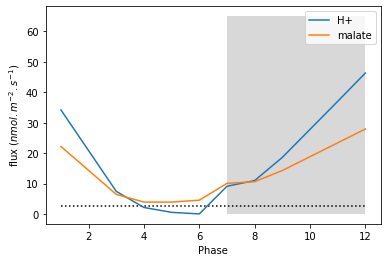

In [12]:
xlist = list()
ylist1 = list()
ylist2 = list()
ylist3 = list()
for i in range(1,13):
    i1 = i
    if i != 12:
        i2 = i+1
    else:
        i2 = 1
    xlist.append(i)
    ylist1.append(sol3["PROTON_v"+str(i)+"_accumulation"])
    ylist2.append(sol3["MAL_v"+str(i)+"_accumulation"]+sol3["aMAL_v"+str(i)+"_accumulation"])
    ylist3.append(ylist1[i-1]/ylist2[i-1])
    

import matplotlib.pyplot as plt

plt.plot(xlist,ylist1,label="H+")
plt.plot(xlist,ylist2,label="malate")
plt.hlines(2.5,1,12,linestyles="dotted")
plt.fill_between(xlist[6:],65,facecolor='grey',alpha=0.3)
plt.legend()
plt.xlabel("Phase")
plt.ylabel("flux ("+r'$ nmol.m^{-2}.s^{-1}$'+")")
plt.show()

In [13]:
i = 10
met = ModelF3.metabolites.get_by_id("PROTON_p"+str(i))

In [14]:
#CBB
cbb_H = 0
rxn = ModelF3.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p"+str(i))
cbb_H = cbb_H+(rxn.flux*rxn.metabolites[met])
# print(cbb_H)
rxn = ModelF3.reactions.get_by_id("PHOSGLYPHOS_RXN_p"+str(i))
cbb_H = cbb_H+(rxn.flux*rxn.metabolites[met])
# print(cbb_H)
rxn = ModelF3.reactions.get_by_id("GAPOXNPHOSPHN_RXN_p"+str(i))
cbb_H = cbb_H+(rxn.flux*rxn.metabolites[met])
# print(cbb_H)
rxn = ModelF3.reactions.get_by_id("PHOSPHORIBULOKINASE_RXN_p"+str(i))
cbb_H = cbb_H+(rxn.flux*rxn.metabolites[met])
cbb_H

0.008041907996378503

In [15]:
#for starch
starch_H = 0
rxn = ModelF3.reactions.get_by_id("GLYCOGENSYN_RXN_p"+str(i))
starch_H = starch_H+(rxn.flux*rxn.metabolites[met])
# print(starch_H)
rxn = ModelF3.reactions.get_by_id("GLUC1PADENYLTRANS_RXN_p"+str(i))
starch_H = starch_H+(rxn.flux*rxn.metabolites[met])
# print(starch_H)
rxn = ModelF3.reactions.get_by_id("INORGPYROPHOSPHAT_RXN_p"+str(i))
starch_H = starch_H+((rxn.flux*rxn.metabolites[met])*(1-(ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p"+str(i)).flux/rxn.flux)))
starch_H

0.0001207101697982511

In [16]:
#PK --> I looked only to PPDK (PYR --> PEP)
pk_H = 0
rxn = ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p"+str(i))
pk_H = pk_H+(rxn.flux*rxn.metabolites[met])
rxn = ModelF3.reactions.get_by_id("INORGPYROPHOSPHAT_RXN_p"+str(i))
pk_H = pk_H+((rxn.flux*rxn.metabolites[met])*ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p"+str(i)).flux/rxn.flux)
rxn = ModelF3.reactions.get_by_id("ADENYL_KIN_RXN_p"+str(i))
pk_H = pk_H+(rxn.flux*rxn.metabolites[met])
pk_H

-6.584191079904606e-05

In [17]:
#sucrose synthesis
SS_H = 0
met = ModelF3.metabolites.get_by_id("PROTON_c"+str(i))
rxn = ModelF3.reactions.get_by_id("UDPKIN_RXN_c"+str(i))
SS_H = SS_H+(rxn.flux*rxn.metabolites[met])
rxn = ModelF3.reactions.get_by_id("SUCROSE_SYNTHASE_RXN_c"+str(i))
SS_H = SS_H+(rxn.flux*rxn.metabolites[met])
rxn = ModelF3.reactions.get_by_id("GLUC1PURIDYLTRANS_RXN_c"+str(i))
SS_H = SS_H+(rxn.flux*rxn.metabolites[met])
rxn = ModelF3.reactions.get_by_id("SUCROSE_PHOSPHATASE_RXN_c"+str(i))
SS_H = SS_H+(rxn.flux*rxn.metabolites[met])
rxn = ModelF3.reactions.get_by_id("INORGPYROPHOSPHAT_RXN_c"+str(i))
SS_H = SS_H+(rxn.flux*rxn.metabolites[met])
rxn = ModelF3.reactions.get_by_id("SUCROSE_PHOSPHATE_SYNTHASE_RXN_c"+str(i))
SS_H = SS_H+(rxn.flux*rxn.metabolites[met])
SS_H

0.0004325200994667601

In [18]:
#sucrose synthesis
GNG_H = 0
rxn = ModelF3.reactions.get_by_id("PHOSGLYPHOS_RXN_c"+str(i))
GNG_H = GNG_H+(rxn.flux*rxn.metabolites[met])
rxn = ModelF3.reactions.get_by_id("F16BDEPHOS_RXN_c"+str(i))
GNG_H = GNG_H+(rxn.flux*rxn.metabolites[met])
rxn = ModelF3.reactions.get_by_id("GAPOXNPHOSPHN_RXN_c"+str(i))
GNG_H = GNG_H+(rxn.flux*rxn.metabolites[met])
GNG_H

8.299676335025584

In [19]:
#general worksheet for figures
  
met = ModelF3.metabolites.PROTON_v12

for rxn in met.reactions:
    if round(rxn.flux,3)!=0:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print(rxn.flux)
        print("-------")

# met = ModelF3.metabolites.OXALACETIC_ACID_c1
# for rxn in met.reactions:
#     if round(rxn.flux,3)!=0:
#         print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
#         print(rxn.reaction)
#         print(rxn.flux)
#         print("-------")

# met = ModelF3.metabolites.PYRUVATE_m9
# for rxn in met.reactions:
#     if round(rxn.flux,3)!=0:
#         print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
#         print(rxn.reaction)
#         print(rxn.flux)
#         print("-------")
        
# met = ModelF3.metabolites.NADH_m1
# for rxn in met.reactions:
#     if round(rxn.flux,3)!=0:
#         print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
#         print(rxn.reaction)
#         print(rxn.flux)
#         print("-------")

MAL_PROTON_vc12	-1.3647577545842866
MAL_c12 + 0.3 PROTON_v12 --> 0.7 MAL_v12 + 0.3 aMAL_v12
4.549192515280955
-------
PROTONATP_rev_vc12	11.347061603945479
0.65 ATP_c12 + 1.45 PROTON_c12 + WATER_c12 + 0.35 aATP_c12 --> 0.5 ADP_c12 + 2.0 PROTON_v12 + 0.7 Pi_c12 + 0.5 aADP_c12 + 0.3 aPi_c12
5.673530801972739
-------
PROTON_v11_accumulation	37.00402958138266
PROTON_v11 --> PROTON_v12
37.00402958138266
-------
PROTON_v12_accumulation	-46.32600228018982
PROTON_v12 --> PROTON_v1
46.32600228018982
-------
CIT_PROTON_vc12	-0.30847713119610937
CIT_c12 + 0.5 PROTON_v12 --> 0.5 CIT_v12 + 0.5 aCIT_v12
0.6169542623922187
-------
SUCROSE_PROTON_rev_vc12	-0.35185401935791694
PROTON_v12 + SUCROSE_v12 --> PROTON_c12 + SUCROSE_c12
0.35185401935791694
-------


In [20]:
#check activity of TCA cycle 
met = ModelF3.metabolites.CIT_m1

for rxn in met.reactions:
    if round(rxn.flux,3)!=0:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print(rxn.flux)
        print("-------")

In [92]:
#summarizing top 5 proton producing/consuming reactions during daytime and nighttime relative to the cytosol
#Daytime
fout = open("DaytimeProducing.csv","w")
for i in range(1,7):
    met = ModelF3.metabolites.get_by_id("PROTON_c"+str(i))
    for rxn in met.reactions:
        if round(rxn.flux,3)!=0 and rxn.flux*rxn.metabolites[met]>0:
            fout.write(rxn.id+","+str(rxn.flux*rxn.metabolites[met])+"\n") 
                        
fout.close()

df = pd.read_csv('DaytimeProducing.csv', header=None)
df.rename(columns={0: 'RxnID', 1: 'DaytimeFlux'}, inplace=True)
df['RxnID'] = df['RxnID'].map(lambda x: str(x)[:-1])
df.to_csv('DaytimeProducing.csv', index=False)
dff = df.groupby(['RxnID']).DaytimeFlux.sum().reset_index()
dff.sort_values("DaytimeFlux", axis=0, ascending=False, inplace=True, na_position='first') 
dff.to_csv('DaytimeProducing.csv', index=True)


fout = open("DaytimeConsuming.csv","w")
for i in range(1,7):
    met = ModelF3.metabolites.get_by_id("PROTON_c"+str(i))
    for rxn in met.reactions:
        if round(rxn.flux,3)!=0 and rxn.flux*rxn.metabolites[met]<0:
            fout.write(rxn.id+","+str(rxn.flux*rxn.metabolites[met])+"\n") 
                        
fout.close()

df = pd.read_csv('DaytimeConsuming.csv', header=None)
df.rename(columns={0: 'RxnID', 1: 'DaytimeFlux'}, inplace=True)
df['RxnID'] = df['RxnID'].map(lambda x: str(x)[:-1])
df.to_csv('DaytimeConsuming.csv', index=False)
dff = df.groupby(['RxnID']).DaytimeFlux.sum().reset_index()
dff.sort_values("DaytimeFlux", axis=0, ascending=True, inplace=True, na_position='first') 
dff.to_csv('DaytimeConsuming.csv', index=True)

#Nighttime
fout = open("NighttimeProducing.csv","w")
for i in range(7,13):
    met = ModelF3.metabolites.get_by_id("PROTON_c"+str(i))
    for rxn in met.reactions:
        if round(rxn.flux,3)!=0 and rxn.flux*rxn.metabolites[met]>0:
            fout.write(rxn.id+","+str(rxn.flux*rxn.metabolites[met])+"\n") 
                        
fout.close()

df = pd.read_csv('NighttimeProducing.csv', header=None)
df.rename(columns={0: 'RxnID', 1: 'NighttimeFlux'}, inplace=True)
df['RxnID'] = df['RxnID'].map(lambda x: str(x)[:-1])
df['RxnID'] = df['RxnID'].map(lambda x: x.rstrip('1'))
df.to_csv('NighttimeProducing.csv', index=False)
dff = df.groupby(['RxnID']).NighttimeFlux.sum().reset_index()
dff.sort_values("NighttimeFlux", axis=0, ascending=False, inplace=True, na_position='first') 
dff.to_csv('NighttimeProducing.csv', index=True)

fout = open("NighttimeConsuming.csv","w")
for i in range(7,13):
    met = ModelF3.metabolites.get_by_id("PROTON_c"+str(i))
    for rxn in met.reactions:
        if round(rxn.flux,3)!=0 and rxn.flux*rxn.metabolites[met]<0:
            fout.write(rxn.id+","+str(rxn.flux*rxn.metabolites[met])+"\n") 
                        
fout.close()

df = pd.read_csv('NighttimeConsuming.csv', header=None)
df.rename(columns={0: 'RxnID', 1: 'NighttimeFlux'}, inplace=True)
df['RxnID'] = df['RxnID'].map(lambda x: str(x)[:-1])
df['RxnID'] = df['RxnID'].map(lambda x: x.rstrip('1'))
df.to_csv('NighttimeConsuming.csv', index=False)
dff = df.groupby(['RxnID']).NighttimeFlux.sum().reset_index()
dff.sort_values("NighttimeFlux", axis=0, ascending=True, inplace=True, na_position='first') 
dff.to_csv('NighttimeConsuming.csv', index=True)

In [ ]:
#check flux through H_mc
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("1_PERIOD_1_PERIOD_1_PERIOD_39_RXN_m"+str(i))
    print(rxn.reaction)
    print(rxn.flux)
    print("--------------------")
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("H_mc"+str(i))
    print(rxn.reaction)
    print(rxn.flux)
    print("--------------------")
# for i in range(1,13):
#     rxn = ModelF3.reactions.get_by_id("PYR_H_mc"+str(i)+"_antiport")
#     print(rxn.reaction)
#     print(rxn.flux)
#     print("--------------------")
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("PYRUVATE_PROTON_mc"+str(i))
    print(rxn.reaction)
    print(rxn.flux)

In [ ]:
#check flux through PEPC
PEPC_rxn = ModelF.reactions.get_by_id("PEPCARBOX_RXN_c1")
print(PEPC_rxn.flux)
print("----------")

#Pyruvate consumed in mitochondria?
met = ModelF3.metabolites.PYRUVATE_m9

for rxn in met.reactions:
    if round(rxn.flux,3)!=0:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print(rxn.flux)
        print("-------")

In [ ]:
#check fluxes through malic enzyme and PPDK
rxn = ModelF3.reactions.get_by_id("1_PERIOD_1_PERIOD_1_PERIOD_39_RXN_m3")
print(rxn.reaction)
print(rxn.flux)
rxn = ModelF3.reactions.get_by_id("MALIC_NADP_RXN_c3")
print(rxn.reaction)
print(rxn.flux)
rxn = ModelF3.reactions.get_by_id("MALIC_NADP_RXN_p3")
print(rxn.reaction)
print(rxn.flux)
rxn = ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p3")
print(rxn.reaction)
print(rxn.flux)
rxn = ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c3")
print(rxn.reaction)
print(rxn.flux)
rxn = ModelF3.reactions.get_by_id("PYRUVATE_PROTON_mc3")
print(rxn.reaction)
print(rxn.flux)

In [ ]:
#cyclic and linear electron transport fluxes 
#cyclic
rxn = ModelF3.reactions.get_by_id("Ferredoxin_Plastoquinone_Reductase_p7")
print(rxn.reaction)
print(rxn.flux)

#linear
rxn = ModelF3.reactions.get_by_id("1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p7")
print(rxn.reaction)
print(rxn.flux)

In [ ]:
#mitochondrial and chloroplastic ATPsynthase
rxn = ModelF3.reactions.get_by_id("Mitochondrial_ATP_Synthase_m5")
print(rxn.reaction)
print(rxn.flux)
print("-----------")
rxn = ModelF3.reactions.get_by_id("Plastidial_ATP_Synthase_p5")
print(rxn.reaction)
print(rxn.flux)

In [ ]:
#random check of reaction 
i = 6
met = ModelF3.metabolites.get_by_id("PROTON_p"+str(i))
rxn = ModelF3.reactions.get_by_id("MALATE_DEHYDROGENASE_NADP_RXN_p6")
print(rxn.reaction)
print(rxn.flux)
print(rxn.flux*rxn.metabolites[met])
print("----------------------")

rxn = ModelF3.reactions.get_by_id("OAA_MAL_pc12")
print(rxn.reaction)
print(rxn.flux)

In [ ]:
#check flux of starch synthesis
starch = 0
for i in range(1,7):
    rxn = ModelF3.reactions.get_by_id("GLYCOGENSYN_RXN_p"+str(i))
    print(rxn.reaction)
    print(rxn.flux)
    starch = starch+rxn.flux
print("---------------")
print("Total starch synthesized: "+str(starch))

In [ ]:
#check flux through rubisco oxygenase and carboxylase
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("RXN_961_p"+str(i))
    print(rxn.reaction)
    print(rxn.flux)
print("-----------------------")
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p"+str(i))
    print(rxn.reaction)
    print(rxn.flux)

In [ ]:
#reactions involved in glycine decarboxylase --> happens halfway through photorespiratory pathway
#if same flux for GCVMULTI and GLYOHMETRANS --> evidence for complete glycine decarboxylase 
#so glycine maybe used to generate serine 
rxn = ModelF3.reactions.get_by_id("GCVMULTI_RXN_m2")
print(rxn.reaction)
print(rxn.flux)
rxn = ModelF3.reactions.get_by_id("GLYOHMETRANS_RXN_m2")
print(rxn.reaction)
print(rxn.flux)
rxn = ModelF3.reactions.get_by_id("GLYOHMETRANS_RXN_c2")
print(rxn.reaction)
print(rxn.flux)

In [ ]:
#random checks of reactions 
ATPADP_rxn = ModelF3.reactions.get_by_id("ATP_ADP_Pi_pc1")
print(ATPADP_rxn.flux)

i = 5
met = ModelF3.metabolites.get_by_id("PROTON_p"+str(i))
rxn = ModelF3.reactions.get_by_id("GLY3KIN_RXN_p5")
print(rxn.reaction)
print(rxn.flux)
print(rxn.flux*rxn.metabolites[met])

#check flux through malate valve
met = ModelF3.metabolites.OXALACETIC_ACID_p1
for rxn in met.reactions:
    if round(rxn.flux,3)!=0:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print("-------")

met = ModelF3.metabolites.OXALACETIC_ACID_p2
for rxn in met.reactions:
    if round(rxn.flux,3)!=0:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print("-------")
        
#checking which reactions produce PPi
met = ModelF3.metabolites.PPI_p1
for rxn in met.reactions:
    if round(rxn.flux,3)!=0:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print("-------")
        
#checking flux of reactions involving photons (light) --> link to linear electron transport 
met = ModelF3.metabolites.Reduced_ferredoxins_p1
for rxn in met.reactions:
    if round(rxn.flux,3)!=0:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print("-------")
        
#is there any sucrose accumulation? 
met = ModelF3.metabolites.SUCROSE_v1
for rxn in met.reactions:
    if round(rxn.flux,3)!=0:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print("-------")

In [ ]:
#serine used to produce hydroxypyruvate?
met = ModelF3.metabolites.OH_PYR_x6

for rxn in met.reactions:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print(rxn.flux)
        print("-------")

In [ ]:
constrained = dict()
for rxn in ModelF3.reactions:
    if (rxn.upper_bound != 0 and rxn.upper_bound != 1000) or (rxn.lower_bound != 0 and rxn.lower_bound != -1000):
        constrained[rxn.id]={"ub":rxn.upper_bound,"lb":rxn.lower_bound}

In [ ]:
for rxnID in sorted(constrained.keys()):
    print(rxnID)
    print(constrained[rxnID])

In [ ]:
met = ModelF3.metabolites.aMAL_v1
for rxn in met.reactions:
    if round(rxn.flux,3)!=0:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print(rxn.flux)
        print("-------")

In [ ]:
met = ModelF3.metabolites.MAL_v1
for rxn in met.reactions:
    if round(rxn.flux,3)!=0:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print(rxn.flux)
        print("-------")

In [ ]:
#write csv file with all reactions of all model phases included
# fout = open("File4Sanu.csv","w")

# for rxn in ModelF3.reactions:
#     fout.write(rxn.id+","+str(rxn.flux)+"\n")
    
# fout.close()

In [ ]:
#Flux variability analysis for daytime fluxes
# reactionsDay = []
# for i in range(1,7):
#     rxn1 = ModelF3.reactions.get_by_id("MAL_PROTON_rev_vc"+str(i))
#     reactionsDay.append(rxn1)
#     rxn2 = ModelF3.reactions.get_by_id("Pi_PROTON_mc"+str(i))
#     reactionsDay.append(rxn2)
#     rxn3 = ModelF3.reactions.get_by_id("ATP_ADP_mc"+str(i))
#     reactionsDay.append(rxn3)
#     rxn4 = ModelF3.reactions.get_by_id("Mitochondrial_ATP_Synthase_m"+str(i))
#     reactionsDay.append(rxn4)
#     rxn5 = ModelF3.reactions.get_by_id("2KG_ISOCITRATE_mc"+str(i))
#     reactionsDay.append(rxn5)
#     rxn6 = ModelF3.reactions.get_by_id("MALATE_DEH_RXN_c"+str(i))
#     reactionsDay.append(rxn6)
#     rxn7 = ModelF3.reactions.get_by_id("GAPOXNPHOSPHN_RXN_c"+str(i))
#     reactionsDay.append(rxn7)
#     rxn8 = ModelF3.reactions.get_by_id("PEP_Pi_pc"+str(i))
#     reactionsDay.append(rxn8)
#     rxn9 = ModelF3.reactions.get_by_id("PHOSPHORIBULOKINASE_RXN_p"+str(i))
#     reactionsDay.append(rxn9)
#     rxn10 = ModelF3.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p"+str(i))
#     reactionsDay.append(rxn10)
#     rxn11 = ModelF3.reactions.get_by_id("GLYCOGENSYN_RXN_p"+str(i))
#     reactionsDay.append(rxn11)
#     rxn12 = ModelF3.reactions.get_by_id("1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p"+str(i))
#     reactionsDay.append(rxn12)
#     rxn13 = ModelF3.reactions.get_by_id("1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p"+str(i))
#     reactionsDay.append(rxn13)
#     rxn14 = ModelF3.reactions.get_by_id("INORGPYROPHOSPHAT_RXN_p"+str(i))
#     reactionsDay.append(rxn14)
#     rxn15 = ModelF3.reactions.get_by_id("Plastidial_ATP_Synthase_p"+str(i))
#     reactionsDay.append(rxn15)
#     rxn16 = ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p"+str(i))
#     reactionsDay.append(rxn16)
#     rxn17 = ModelF3.reactions.get_by_id("MALATE_DEHYDROGENASE_NADP_RXN_p"+str(i))
#     reactionsDay.append(rxn17)
#     rxn18 = ModelF3.reactions.get_by_id("ADENYL_KIN_RXN_p"+str(i))
#     reactionsDay.append(rxn18)
     
# from cobra.flux_analysis.variability import flux_variability_analysis
# fva_sol = flux_variability_analysis(ModelF3,reaction_list=reactionsDay,pfba_factor=1)
# print(fva_sol)

In [ ]:
#Flux variability analysis for nighttime fluxes
# reactionsNight = []
# for i in range(7,13):
#     rxn1 = ModelF3.reactions.get_by_id("PROTONATP_rev_vc"+str(i))
#     reactionsNight.append(rxn1)
#     rxn2 = ModelF3.reactions.get_by_id("Mitochondrial_ATP_Synthase_m"+str(i))
#     reactionsNight.append(rxn2)
#     rxn3 = ModelF3.reactions.get_by_id("Pi_PROTON_mc"+str(i))
#     reactionsNight.append(rxn3)
#     rxn4 = ModelF3.reactions.get_by_id("GAPOXNPHOSPHN_RXN_c"+str(i))
#     reactionsNight.append(rxn4)
#     rxn5 = ModelF3.reactions.get_by_id("RXN0_5224_c"+str(i))
#     reactionsNight.append(rxn5)
#     rxn6 = ModelF3.reactions.get_by_id("G6P_Pi_pc"+str(i))
#     reactionsNight.append(rxn6)
#     rxn7 = ModelF3.reactions.get_by_id("MALATE_DEH_RXN_c"+str(i))
#     reactionsNight.append(rxn7)
#     rxn8 = ModelF3.reactions.get_by_id("PHOSPHORIBULOKINASE_RXN_p"+str(i))
#     reactionsNight.append(rxn8)
#     rxn9 = ModelF3.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p"+str(i))
#     reactionsNight.append(rxn9)
#     rxn10 = ModelF3.reactions.get_by_id("PEPDEPHOS_RXN_p"+str(i))
#     reactionsNight.append(rxn10)
     
# from cobra.flux_analysis.variability import flux_variability_analysis
# fva_sol = flux_variability_analysis(ModelF3,reaction_list=reactionsNight,pfba_factor=1)
# print(fva_sol)

In [ ]:
# FVA on important CAM reactions day
# reactionsCAM = []
# for i in range(1,7):
#     rxn1 = ModelF3.reactions.get_by_id("MALIC_NADP_RXN_c"+str(i))
#     reactionsCAM.append(rxn1)
#     rxn2 = ModelF3.reactions.get_by_id("MALIC_NADP_RXN_p"+str(i))
#     reactionsCAM.append(rxn2)
#     rxn3 = ModelF3.reactions.get_by_id("1_PERIOD_1_PERIOD_1_PERIOD_39_RXN_m"+str(i))
#     reactionsCAM.append(rxn3)
#     rxn4 = ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p"+str(i))
#     reactionsCAM.append(rxn4)
#     rxn5 = ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c"+str(i))
#     reactionsCAM.append(rxn5)
     
# from cobra.flux_analysis.variability import flux_variability_analysis
# fva_sol = flux_variability_analysis(ModelF3,reaction_list=reactionsCAM,pfba_factor=1)
# print(fva_sol)

In [ ]:
#FVA on important CAM reactions night
# reactionsCAM = []
# for i in range(7,13):
#     rxn1 = ModelF3.reactions.get_by_id("PEPCARBOX_RXN_c"+str(i))
#     reactionsCAM.append(rxn1)
#     rxn2 = ModelF3.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p"+str(i))
#     reactionsCAM.append(rxn2)
     
# from cobra.flux_analysis.variability import flux_variability_analysis
# fva_sol = flux_variability_analysis(ModelF3,reaction_list=reactionsCAM,pfba_factor=1)
# print(fva_sol)